<a href="https://colab.research.google.com/github/Akechi1412/Sentiment-Analysis/blob/main/notebooks/sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Sentiment Analysis of Product Reviews**

## **Connect to Drive and Github responsitory**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Github
# !git clone https://github.com/Akechi1412/Sentiment-Analysis.git
%cd Sentiment-Analysis
!git config --global user.email 'nguyenphong10042002@gmail.com'
!git config --global user.name 'Akechi1412'
!git fetch origin
!git reset --hard origin/main

/content/drive/MyDrive/Github
/content/drive/.shortcut-targets-by-id/1s7C_pXybLyG2ZPrSW0ni6I01zFpbMZ8j/Sentiment-Analysis
Updating files: 100% (11/11), done.
HEAD is now at 9a3d682 Created using Colab


## **Data Collecting**

From [Vietnamese Sentiment Analyst](https://www.kaggle.com/datasets/linhlpv/vietnamese-sentiment-analyst/data)

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('data/data - data.csv')
print(df.head())
print(len(df['comment']))

                       comment label  rate Unnamed: 3
0               Áo bao đẹp ạ!!   POS     5        NaN
1                  Tuyệt vời !   POS     5        NaN
2   2day ao khong giong trong.   NEG     1        NaN
3  Mùi thơm,bôi lên da mềm da.   POS     5        NaN
4            Vải đẹp, dày dặn.   POS     5        NaN
31460


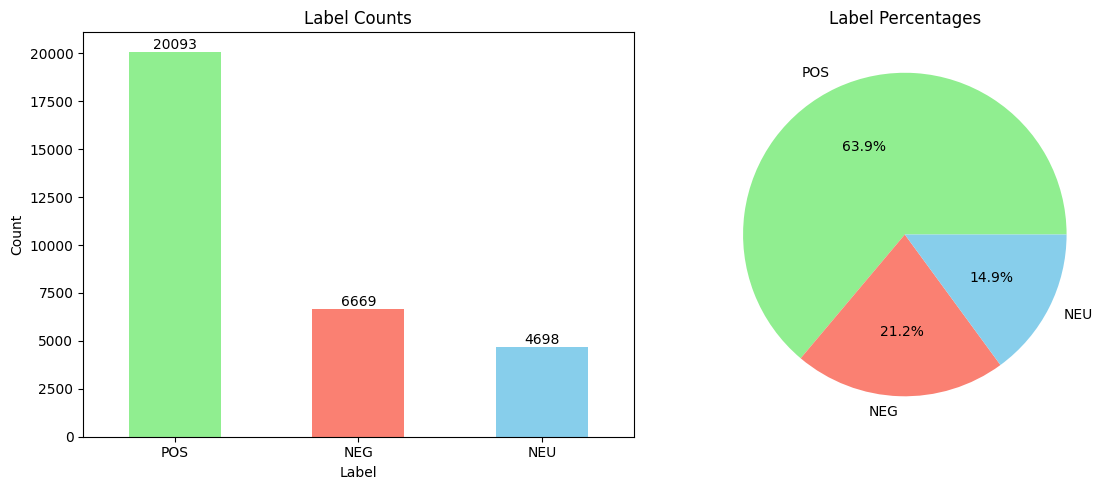

In [5]:
# Count the labels
label_counts = df['label'].value_counts()

# Calculate label percentages
label_percentages = label_counts / label_counts.sum() * 100

# Create a figure with two subplots
plt.figure(figsize=(12, 5))

# Bar plot for label counts
plt.subplot(1, 2, 1)
bars = label_counts.plot(kind='bar', color=['lightgreen', 'salmon', 'skyblue'])
plt.title('Label Counts')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)

# Add the exact count on top of each bar
for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.05, f'{int(bar.get_height())}',
             ha='center', va='bottom', color='black')

# Pie chart for label percentages
plt.subplot(1, 2, 2)
label_percentages.plot(kind='pie', autopct='%1.1f%%', colors=['lightgreen', 'salmon', 'skyblue'])
plt.title('Label Percentages')
plt.ylabel('')

plt.tight_layout()
plt.show()

## **Data preprocessing**

In [6]:
!pip install underthesea emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 86.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 61.1 MB/s eta 0:00:00


In [7]:
from utils.data_preprocessing import clean_text
import seaborn as sns
import numpy as np
from collections import Counter
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
import pickle
from transformers import AutoTokenizer
import tensorflow as tf
from sklearn.model_selection import StratifiedShuffleSplit

In [8]:
df['cleaned_comment'] = df['comment'].apply(clean_text)
filtered_df = df[df['cleaned_comment'].str.len() > 1]
x_data = filtered_df['cleaned_comment'].tolist()
y_data = filtered_df['label'].tolist()

print(len(x_data), len(y_data))

31358 31358


In [9]:
split1 = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
for train_idx, temp_idx in split1.split(x_data, y_data):
    x_train = [x_data[i] for i in train_idx]
    y_train = [y_data[i] for i in train_idx]
    x_temp = [x_data[i] for i in temp_idx]
    y_temp = [y_data[i] for i in temp_idx]

split2 = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=42)
for val_idx, test_idx in split2.split(x_temp, y_temp):
    x_val = [x_temp[i] for i in val_idx]
    y_val = [y_temp[i] for i in val_idx]
    x_test = [x_temp[i] for i in test_idx]
    y_test = [y_temp[i] for i in test_idx]

print(f"Train: {len(x_train)}, Validation: {len(x_val)}, Test: {len(x_test)}")

Train: 21950, Validation: 4704, Test: 4704


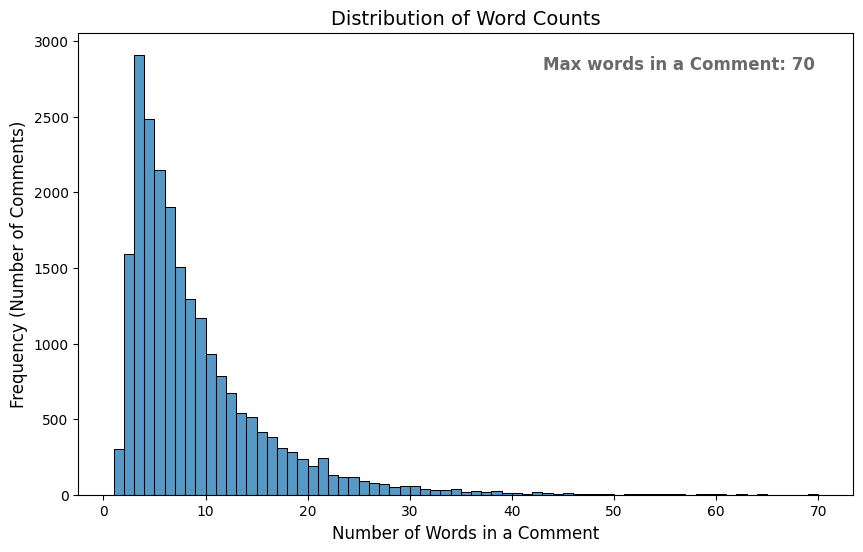

In [10]:
word_counts = [len(item.split()) for item in x_train]
max_word_count = max(word_counts)

plt.figure(figsize=(10, 6))
sns.histplot(word_counts, bins=range(1, max_word_count+1), kde=False)
plt.title('Distribution of Word Counts', fontsize=14)
plt.xlabel('Number of Words in a Comment', fontsize=12)
plt.ylabel('Frequency (Number of Comments)', fontsize=12)
plt.text(
    x=0.95, y=0.95,
    s=f'Max words in a Comment: {max_word_count}',
    color='dimgray', fontsize=12, fontweight='bold', ha='right', va='top',
    transform=plt.gca().transAxes
)
plt.show()

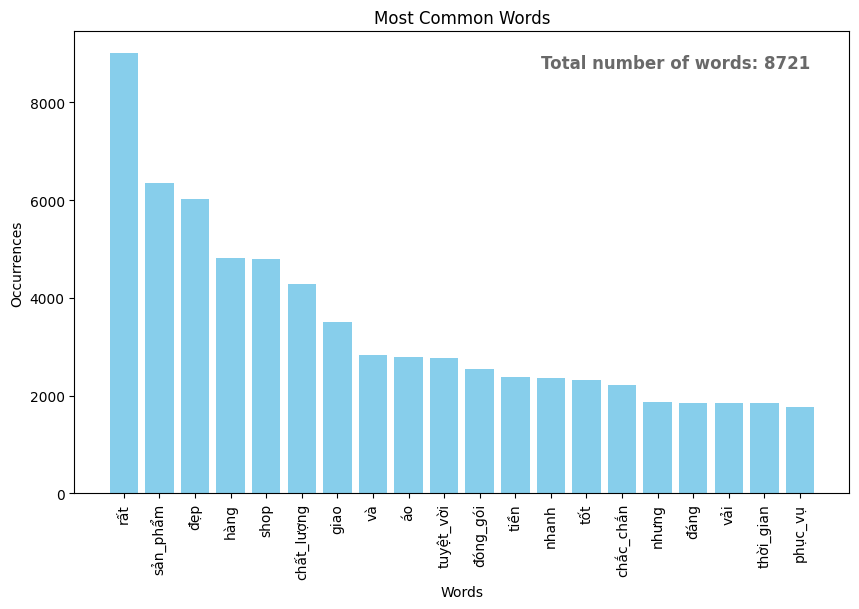

In [11]:
words = [word for comment in x_train for word in comment.split()]
word_counts = Counter(words)
most_common_words = Counter(words).most_common(20)
labels, values = zip(*most_common_words)

plt.figure(figsize=(10, 6))
plt.bar(labels, values, color='skyblue')
plt.xlabel('Words')
plt.ylabel('Occurrences')
plt.title('Most Common Words')
plt.xticks(rotation=90)
plt.text(
    x=0.95, y=0.95, s=f'Total number of words: {len(word_counts)}',
    color='dimgray', fontsize=12, fontweight='bold', ha='right', va='top',
    transform=plt.gca().transAxes
)
plt.show()

In [12]:
# Tokenize text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)

x_train_seq = tokenizer.texts_to_sequences(x_train)
x_val_seq = tokenizer.texts_to_sequences(x_val)
x_test_seq = tokenizer.texts_to_sequences(x_test)

# Save tokenize
with open('./models/tokenizer.pkl', 'wb') as file:
    pickle.dump(tokenizer, file)

# Pad sequences to ensure uniform length
max_len = 50
x_train_pad = pad_sequences(x_train_seq, maxlen=max_len)
x_val_pad = pad_sequences(x_val_seq, maxlen=max_len)
x_test_pad = pad_sequences(x_test_seq, maxlen=max_len)

In [13]:
# Encode label
label_encoder = LabelEncoder()
label_encoder.fit(np.concatenate([y_train, y_val, y_test]))

y_train_encoded = label_encoder.transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)

label_mapping = dict(zip(label_encoder.classes_,
                         range(len(label_encoder.classes_))))
print('Label mapping:', label_mapping)

Label mapping: {'NEG': 0, 'NEU': 1, 'POS': 2}


## **Training**

In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model, models, layers, regularizers, optimizers

In [15]:
# Input
input = layers.Input(shape=(max_len,))

# Embedding Layer
embedding_output = layers.Embedding(
    input_dim=len(tokenizer.word_index) + 1,
    output_dim=100
)(input)

# BiLSTM Layer
lstm_output = layers.Bidirectional(
    layers.LSTM(128, return_sequences=True, dropout=0.2, recurrent_dropout=0.2)
)(embedding_output)

# Global Average Pooling and Global Max Pooling
avg_pool = layers.GlobalAveragePooling1D()(lstm_output)
max_pool = layers.GlobalMaxPooling1D()(lstm_output)

# Concatenate Pooling Outputs
concat = layers.Concatenate()([avg_pool, max_pool])

# Fully Connected Layers
dense_1 = layers.Dense(512, activation='relu',
                       kernel_regularizer=regularizers.L2(1e-6))(concat)
dropout_1 = layers.Dropout(0.3)(dense_1)
dense_2 = layers.Dense(512, activation='relu',
                       kernel_regularizer=regularizers.L2(1e-6))(dropout_1)
dropout_2 = layers.Dropout(0.3)(dense_2)

# Output Layer
output = layers.Dense(3, activation='softmax')(dropout_2)

# Final Model
model = Model(inputs=input, outputs=output)

# Compile Model
optimizer = optimizers.Adam(learning_rate=1e-3)
metrics = [tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')]

model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=metrics
)

# Model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 50)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 50, 100)        │        463,000 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bidirectional             │ (None, 50, 256)        │        234,496 │ embedding[0][0]        │
│ (Bidirectional)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d  │ (None, 256)            │              0 │ bidirectional[0][0]    │
│ (GlobalAveragePooling1D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_max_pooling1d      │ (None, 256)            │              0 │ bidirectional[0][0]    │
│ (GlobalMaxPooling1D)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 512)            │              0 │ global_average_poolin… │
│                           │                        │                │ global_max_pooling1d[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 512)            │        262,656 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 512)            │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 512)            │        262,656 │ dropout[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 512)            │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 3)              │          1,539 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,224,347 (4.67 MB)

 Trainable params: 1,224,347 (4.67 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
checkpoint_filepath = 'models/best_model.keras'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

history = model.fit(
    x=x_train_pad,
    y=y_train_encoded,
    validation_data=(x_val_pad, y_val_encoded),
    batch_size=64,
    epochs=20,
    callbacks=[checkpoint_callback, early_stopping]
)

Epoch 1/20
343/343 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.7037 - loss: 0.7164
Epoch 1: val_loss improved from inf to 0.55734, saving model to models/best_model.keras
343/343 ━━━━━━━━━━━━━━━━━━━━ 36s 87ms/step - accuracy: 0.7038 - loss: 0.7160 - val_accuracy: 0.7785 - val_loss: 0.5573
Epoch 2/20
343/343 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.8066 - loss: 0.4841
Epoch 2: val_loss improved from 0.55734 to 0.52159, saving model to models/best_model.keras
343/343 ━━━━━━━━━━━━━━━━━━━━ 29s 85ms/step - accuracy: 0.8066 - loss: 0.4841 - val_accuracy: 0.7919 - val_loss: 0.5216
Epoch 3/20
343/343 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.8261 - loss: 0.4379
Epoch 3: val_loss did not improve from 0.52159
343/343 ━━━━━━━━━━━━━━━━━━━━ 29s 84ms/step - accuracy: 0.8261 - loss: 0.4379 - val_accuracy: 0.7985 - val_loss: 0.5347
Epoch 4/20
343/343 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - accuracy: 0.8404 - loss: 0.4057
Epoch 4: val_loss did not improve from 0.52159
343/343 ━━━━━━━━━━━━━

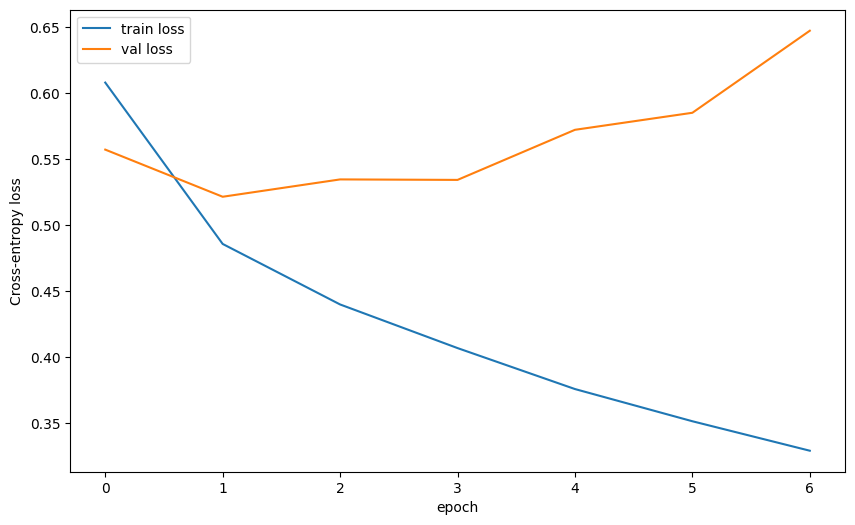

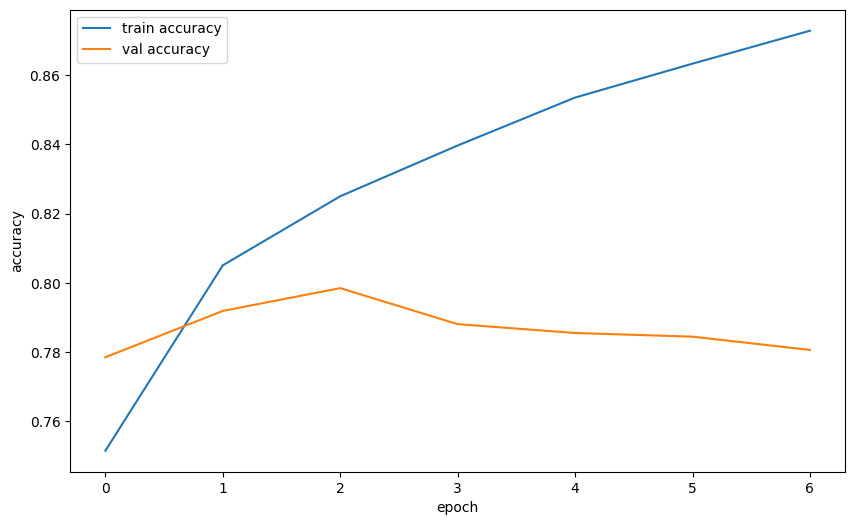

In [17]:
history = model.history

# Plot history loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('epoch')
plt.ylabel('Cross-entropy loss')
plt.legend()
plt.show()

# Plot history accuracy
plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [18]:
model.save('models/best_model.h5')

## **Model Evaluation**

In [19]:
from sklearn.metrics import classification_report, confusion_matrix

In [20]:
y_pred_prob = model.predict(x_test_pad)
y_pred = tf.argmax(y_pred_prob, axis=1).numpy()
print(classification_report(y_test_encoded, y_pred, target_names=['NEG', 'NEU', 'POS']))

147/147 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step
              precision    recall  f1-score   support

         NEG       0.68      0.84      0.75       998
         NEU       0.41      0.24      0.30       701
         POS       0.89      0.91      0.90      3005

    accuracy                           0.80      4704
   macro avg       0.66      0.66      0.65      4704
weighted avg       0.78      0.80      0.78      4704



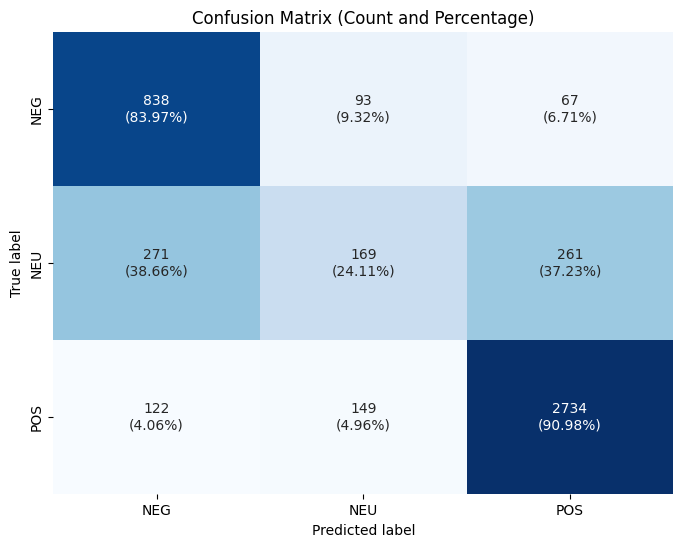

In [21]:
cm = confusion_matrix(y_test_encoded, y_pred)

cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

labels = label_encoder.classes_

formatted_labels = [
    [f'{int(count)}\n({percentage:.2%})' for count, percentage in zip(row_count, row_percentage)]
    for row_count, row_percentage in zip(cm, cm_percentage)
]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_percentage, annot=formatted_labels, fmt='', cmap='Blues', cbar=False,
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix (Count and Percentage)')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()